In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import io
import seaborn as sns
import os
import sys

In [12]:
def preprocess_data(file_path):
    """
    Reads the data from a CSV file and adds necessary columns for visualization.
    """
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"The file '{file_path}' was not found.")
        
    df = pd.read_csv(file_path)
    
    # Calculate 95% Confidence Interval
    # Formula: CI = 1.96 * (std / sqrt(N))
    # We do this for both Chamfer and Swiss metrics
    df['chamfer_ci'] = 1.96 * (df['chamfer_std'] / np.sqrt(df['num_eval_samples']))
    df['swiss_ci'] = 1.96 * (df['swiss_dist_std'] / np.sqrt(df['num_eval_samples']))
    
    # Create a clean label for the X-axis based on Tangent/Normal Ratio
    def get_label_and_sort(row):
        t = row['tangent_fraction']
        n = row['normal_fraction']
        
        if n == 0:
            # Denominator is 0, purely tangent noise
            return f"Tangent Only (T={t})", float('inf')
        else:
            # Ratio T/N
            ratio = t / n
            return f"{ratio:.2f}", ratio

    # Apply function with result_type='expand' to ensure we get a DataFrame with columns 0, 1
    label_sort_df = df.apply(lambda row: get_label_and_sort(row), axis=1, result_type='expand')
    
    # Assign columns individually to be safe (Fixes KeyError issue)
    df['Config_Label'] = label_sort_df[0]
    df['Sort_Key'] = label_sort_df[1]
    
    return df

In [13]:
def plot_bar_charts_by_epoch(df, metric_mean, metric_ci, title_prefix):
    """
    Creates a grid of bar charts, one per Epoch value.
    Ensures consistent X-axis ordering across epochs for comparison.
    """
    unique_epochs = sorted(df['num_epochs'].unique())
    n_epochs = len(unique_epochs)
    
    # Define a consistent order for the configurations based on the Sort_Key (Ratio)
    # This sorts from Normal-dominated (Ratio 0) to Tangent-dominated (Ratio Inf)
    config_order = df.sort_values('Sort_Key')['Config_Label'].unique()
    
    fig, axes = plt.subplots(1, n_epochs, figsize=(6 * n_epochs, 6), sharey=True)
    if n_epochs == 1: axes = [axes] # Handle single plot case
    
    # Determine log scale requirement based on global data range
    use_log = (df[metric_mean].max() / df[metric_mean].min()) > 100
    
    for ax, epoch in zip(axes, unique_epochs):
        # Filter for the current epoch
        subset = df[df['num_epochs'] == epoch]
        
        # We must index the subset by our fixed order to ensure error bars 
        # and labels match the seaborn barplot order
        # Note: We need to handle cases where a config might be missing in a specific epoch
        # reindex will introduce NaNs for missing configs, which barplot handles (empty space)
        subset = subset.set_index('Config_Label').reindex(config_order).reset_index()
        
        sns.barplot(
            data=subset, x='Config_Label', y=metric_mean,
            ax=ax, palette='viridis', edgecolor='black', order=config_order
        )
        
        # Add error bars manually
        # Since we forced the order in 'subset', these line up with the bars
        x_coords = range(len(subset))
        
        # Only plot error bars where data exists
        valid_indices = subset[metric_mean].notna()
        if valid_indices.any():
            ax.errorbar(
                [x for x, valid in zip(x_coords, valid_indices) if valid],
                subset.loc[valid_indices, metric_mean],
                yerr=subset.loc[valid_indices, metric_ci],
                fmt='none', c='black', capsize=5
            )

        ax.set_title(f"Epochs: {epoch}")
        ax.set_xlabel("Noise Config (Tangent/Normal Ratio)")
        
        if use_log: 
            ax.set_yscale('log')
            
        ax.tick_params(axis='x', rotation=45)
        
        # Labels on top
        for i, v in enumerate(subset[metric_mean]):
            if pd.notna(v): # Check for NaN in case of missing data for a config
                ax.text(i, v, f"{v:.1f}", ha='center', va='bottom', fontsize=8, fontweight='bold')

    axes[0].set_ylabel(f"{title_prefix} (Lower is Better)")
    plt.suptitle(f"{title_prefix} by Epoch", fontsize=16)
    plt.tight_layout()
    plt.show()

Generating Visualizations...


/var/folders/rd/mp__2p510kndbjc_f7sc4jz00000gn/T/ipykernel_56425/3595146358.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/rd/mp__2p510kndbjc_f7sc4jz00000gn/T/ipykernel_56425/3595146358.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/rd/mp__2p510kndbjc_f7sc4jz00000gn/T/ipykernel_56425/3595146358.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


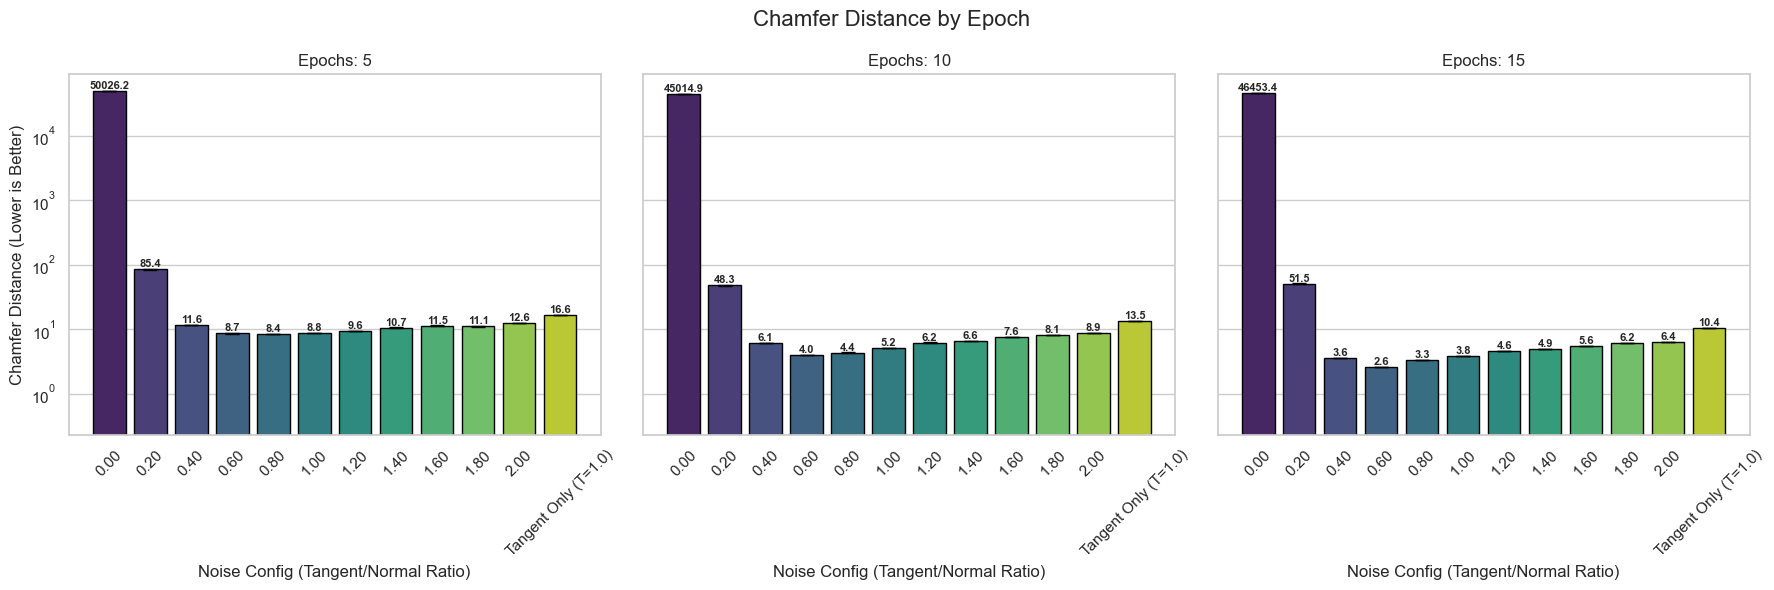

In [14]:
sns.set_theme(style="whitegrid")
    
df = preprocess_data('outputs/full_swissroll_experiments/summary.csv')

print("Generating Visualizations...")

# 1. Chamfer Distance Visuals
plot_bar_charts_by_epoch(df, 'chamfer_mean', 'chamfer_ci', 'Chamfer Distance')

In [22]:
def plot_convergence_lines(df, metric_mean, title_prefix):
    """
    Plots the metric over epochs to show convergence speed.
    """
    plt.figure(figsize=(10, 6))
    
    # Filter out the outlier to prevent graph collapse
    df = df[~df['Config_Label'].isin(["0.00", "0.20"])].copy()
    
    if df.empty:
        print("Warning: All data was filtered out in plot_convergence_lines.")
        return

    use_log = (df[metric_mean].max() / df[metric_mean].min()) > 100
    
    # Sort legend by ratio
    df = df.sort_values('Sort_Key')
    
    sns.lineplot(
        data=df, 
        x='num_epochs', 
        y=metric_mean, 
        hue='Config_Label',
        style='Config_Label',
        markers=True, 
        dashes=False,
        linewidth=2.5,
        palette='tab10',
        hue_order=df['Config_Label'].unique(),
        style_order=df['Config_Label'].unique()
    )
    
    if use_log: plt.yscale('log')
    plt.title(f"{title_prefix}: Convergence over Epochs (Excluding 0.00)")
    plt.ylabel(f"{title_prefix} (Mean)")
    plt.xlabel("Training Epochs")
    plt.grid(True, which="both", linestyle='--', alpha=0.5)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Ratio (T/N)")
    plt.tight_layout()
    plt.show()

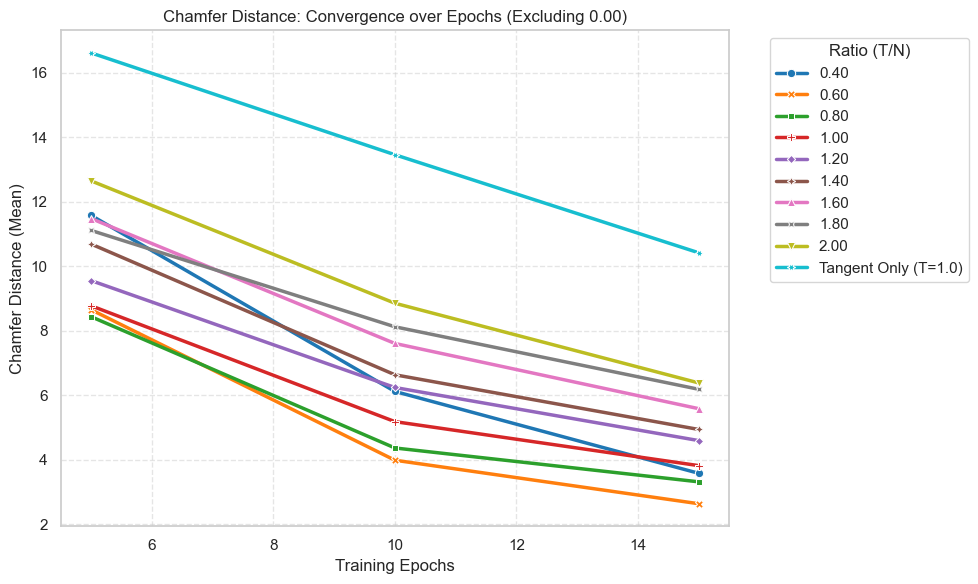

In [23]:
plot_convergence_lines(df, 'chamfer_mean', 'Chamfer Distance')

In [ ]:
def plot_heatmaps(df, metric_mean, title_prefix):
    """
    Creates heatmaps of Tangent vs Normal fraction for the metric.
    One heatmap per Epoch setting (since values change over time).
    """

    unique_epochs = sorted(df['num_epochs'].unique())
    
    fig, axes = plt.subplots(1, len(unique_epochs), figsize=(5 * len(unique_epochs), 5))
    if len(unique_epochs) == 1: axes = [axes]
    
    for ax, epoch in zip(axes, unique_epochs):
        subset = df[df['num_epochs'] == epoch]
        
        # Pivot table: Rows=Tangent, Cols=Normal, Values=Metric
        pivot_table = subset.pivot_table(
            index='tangent_fraction', 
            columns='normal_fraction', 
            values=metric_mean
        )
        
        sns.heatmap(
            pivot_table, 
            annot=True, 
            fmt=".1f", 
            cmap="RdYlGn_r", # Red = High (Bad), Green = Low (Good)
            ax=ax,
            cbar_kws={'label': title_prefix}
        )
        ax.set_title(f"Epochs: {epoch}")
        ax.invert_yaxis() # Standard plot orientation
        
    plt.suptitle(f"{title_prefix} Heatmap (Tangent vs Normal)", fontsize=16)
    plt.tight_layout()
    plt.show()

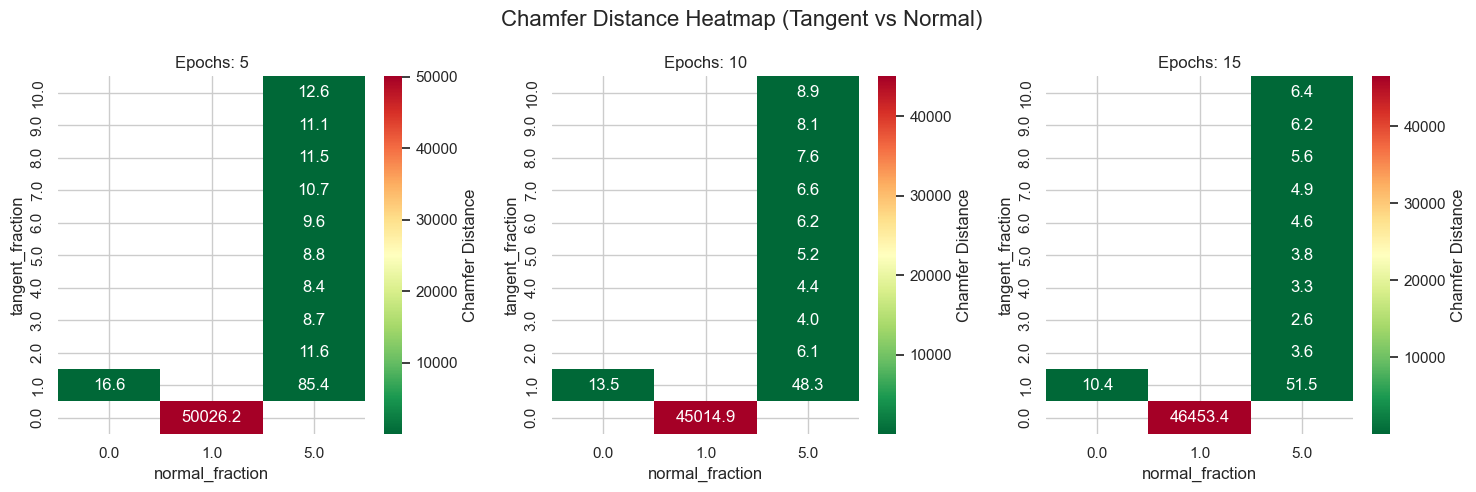

In [27]:
try:
    plot_heatmaps(df, 'chamfer_mean', 'Chamfer Distance')
except Exception as e:
    print(f"Skipping Heatmap: Data might not be dense enough grid. {e}")

Generating Swiss Distance Visuals...


/var/folders/rd/mp__2p510kndbjc_f7sc4jz00000gn/T/ipykernel_56425/3595146358.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/rd/mp__2p510kndbjc_f7sc4jz00000gn/T/ipykernel_56425/3595146358.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/rd/mp__2p510kndbjc_f7sc4jz00000gn/T/ipykernel_56425/3595146358.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


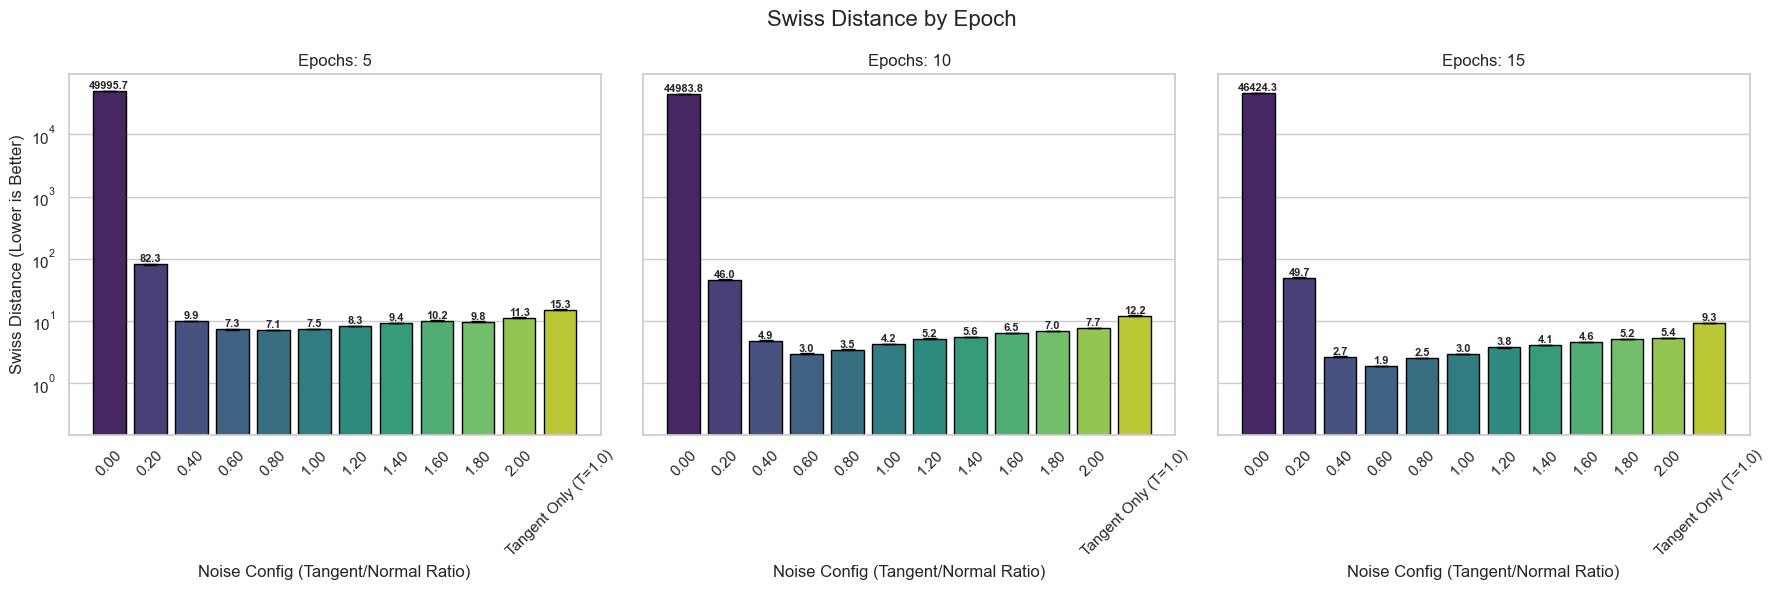

In [30]:
# 2. Swiss Distance Visuals
print("Generating Swiss Distance Visuals...")
plot_bar_charts_by_epoch(df, 'swiss_dist_mean', 'swiss_ci', 'Swiss Distance')


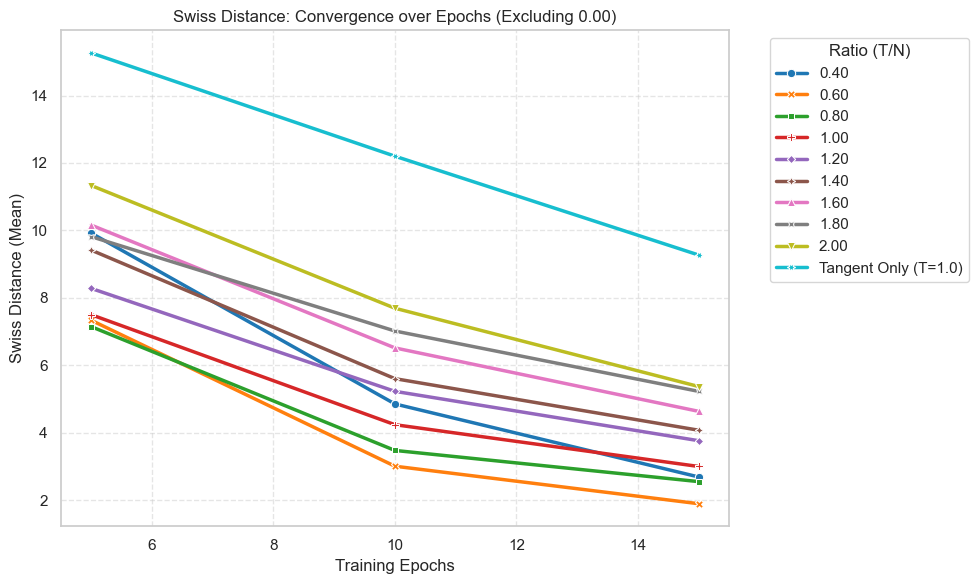

In [31]:
plot_convergence_lines(df, 'swiss_dist_mean', 'Swiss Distance')